In [1]:
import numpy as np
import pandas as pd
import os
import os.path as osp
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import time
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torch.utils.data as data
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import models, transforms
import timm

from bi_tempered_loss_pytorch import bi_tempered_logistic_loss

In [2]:
config = {
    'rootpath': osp.join('..','input','cassava-leaf-disease-classification'),
    'seed': 334,
    'num_folds': 5,
    
    # augmentaion params
    'aug': {
        'ver': 'V3',
#         'size': 512,
#         'size': 384,
        'size': 224,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225),
#         'degrees': 45,
        'degrees': 90,
        'brightness': 0.3,
        'contrast': 0.3,
    },
    
    # loss params
    'loss': {
#         'name': 'CrossEntropyLoss',
        'name': 'BiTemperedLogisticLoss',
        't1': 0.2,
        't2': 1.2,
        'label_smoothing': 0.01,
        'num_iters': 5,
        'reduction': 'mean'
    },

#     'model_name': 'resnet50',
#     'model_name': 'resnext50_32x4d',
#     'model_name': 'seresnext50_32x4d',
    'model_name': 'tf_efficientnet_b4_ns',
    'batch_size': 32,
    'test_batch_size': 1,
    'num_epochs': 15,
    'set_all': True,
    
    # optim params
    'optim': {
#         'name': 'SGD',
        'name': 'Adam',
        'lr': 1e-04,
        'T_0': 10,   # CosineAnnealingWarmRestarts
        'T_mult': 1,   # CosineAnnealingWarmRestarts
        'min_lr': 1e-06,   # CosineAnnealingWarmRestarts
        'last_epoch': -1,   # CosineAnnealingWarmRestarts
        'weight_decay': 1e-06
    }
}


In [3]:
train = pd.read_csv(osp.join(config['rootpath'], 'train.csv'))
train['image_path'] = osp.join(config['rootpath'], 'train_images')
train['image_path'] = train['image_path'].str.cat(train['image_id'], sep=osp.sep)
train.head()

,image_id,label,image_path
0,1000015157.jpg,0,..\input\cassava-leaf-disease-classification\t...
1,1000201771.jpg,3,..\input\cassava-leaf-disease-classification\t...
2,100042118.jpg,1,..\input\cassava-leaf-disease-classification\t...
3,1000723321.jpg,1,..\input\cassava-leaf-disease-classification\t...
4,1000812911.jpg,3,..\input\cassava-leaf-disease-classification\t...


In [4]:
# submission = pd.read_csv(osp.join(config['rootpath'], 'sample_submission.csv'))
# submission.head()

# Preprocessing Class

In [5]:
class ImageTransform():
    def __init__(self, resize, mean, std, degrees=45, brightness=0.3, contrast=0.3):
        self.data_transform = {
            'V1': {
                'train': transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'val': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'test': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])                
            },
            'V2': {
                'train': transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(degrees),
                    transforms.ColorJitter(brightness, contrast),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'val': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'test': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])
            },
            'V3': {
                'train': transforms.Compose([
                    transforms.RandomResizedCrop(resize),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(degrees),
                    transforms.ColorJitter(brightness, contrast),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'val': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'test': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])
            }
        }

    def __call__(self, img, ver='V1', phase='train'):
        return self.data_transform[ver][phase](img)


# Dataset Class

In [6]:
class CassavaDataset(data.Dataset):
    def __init__(self, filepath2label, transform=None, ver='V1', phase='train', output_label=True):
        self.file_list = list(filepath2label.keys())
        self.transform = transform
        self.filepath2label = filepath2label
        self.ver = ver
        self.phase = phase
        self.output_label = output_label
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img, self.ver, self.phase)
        if self.output_label:
            label = self.filepath2label[img_path]
            return img, label
        else:
            return img        

In [7]:
# # 動作確認

# index = 0
# print(train_dataset.__getitem__(index)[0].size())

# DataLoader

In [8]:
def get_DataLoader(dataset, batch_size, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle, pin_memory=True)

In [9]:
# # 動作確認

# batch_iterator = iter(dataloaders_dict['train'])
# inputs, labels = next(batch_iterator)
# print(inputs.size())
# print(labels)

# Make Network model

## ResNext50_32x4d

In [10]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 5, bias=True)

    def forward(self, x):
        x = self.model(x)
        return x

## EfficientNet (b4)

In [11]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b4_ns', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 5)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Get Network

In [12]:
def get_network(model_name, use_pretrained=True):
    if model_name == 'vgg19':
        net = models.vgg19(pretrained=use_pretrained)
        net.classifier[6] = nn.Linear(in_features=4096, out_features=5, bias=True)
        update_param_names = ['classifier.6.weight', 'classifier.6.bias']
    elif model_name == 'resnet50':
        net = models.resnet50(pretrained=use_pretrained)
        net.fc = nn.Linear(in_features=2048, out_features=5, bias=True)
        update_param_names = ['fc.weight', 'fc.bias']
    elif model_name == 'resnext50_32x4d':
        net = CustomResNext(model_name=model_name, pretrained=use_pretrained)
        update_param_names = ['model.fc.weight', 'model.fc.bias']
    elif model_name == 'seresnext50_32x4d':
        net = CustomResNext(model_name=model_name, pretrained=use_pretrained)
        update_param_names = ['model.fc.weight', 'model.fc.bias']
    elif model_name == 'tf_efficientnet_b4_ns':
        net = CustomEfficientNet(model_name=model_name, pretrained=use_pretrained)
        update_param_names = ['model.classifier.weight', 'model.classifier.bias']
    
    return net, update_param_names


# Define Loss function

In [13]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1=0.8, t2=1.4, label_smoothing=0.0, num_iters=5, reduction='mean'):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.label_smoothing = label_smoothing
        self.num_iters = num_iters
        self.reduction = reduction

    def forward(self, outputs, labels):
        loss = bi_tempered_logistic_loss(outputs, labels, t1=self.t1, t2=self.t2, label_smoothing=self.label_smoothing, num_iters=self.num_iters, reduction=self.reduction)
        return loss

In [14]:
def get_criterion(loss, params):
    if loss == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif loss == 'BiTemperedLogisticLoss':
        criterion = BiTemperedLogisticLoss(params['t1'], params['t2'], params['label_smoothing'], params['num_iters'], params['reduction'])
    return criterion

# Set Optimization

In [15]:
def set_params(net, update_param_names, set_all=False):
    # add parameters to learn by fine-tuning to params_to_update
    params_to_update = []

    for name, param in net.named_parameters():
        if set_all:
            param.requires_grad = True
            params_to_update.append(param)
        else:
            if name in update_param_names:
                param.requires_grad = True
                params_to_update.append(param)
                print(name)
            else:
                param.requires_grad = False

#     print("-----------------")
#     print(params_to_update)
    
    return params_to_update

In [16]:
def get_optimizer(optimizer_name, params_to_update):
    # set optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(params=params_to_update, lr=config['optim']['lr'], momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(params=params_to_update, lr=config['optim']['lr'], weight_decay=config['optim']['weight_decay'])
    
    return optimizer

## Scheduler

In [17]:
def get_scheduler(optimizer):
#     if CFG.scheduler=='ReduceLROnPlateau':
#         scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
#     elif CFG.scheduler=='CosineAnnealingLR':
#         scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
#     elif CFG.scheduler=='CosineAnnealingWarmRestarts':
#         scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config['optim']['T_0'], T_mult=config['optim']['T_mult'], eta_min=config['optim']['min_lr'], last_epoch=config['optim']['last_epoch'])
    return scheduler

# Train & Validation

In [18]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, sheduler, device):
    # move network to device
    net.to(device)
    
    # try speeding up
    torch.backends.cudnn.benchmark = True
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    
    # LOOP: epoch
    epoch_result_dict = {'train': {'loss': np.array([]), 'acc': np.array([])}, 'val': {'loss': np.array([]), 'acc': np.array([])}}
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--------------------')
        
        # LOOP: train & valid at each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()   # set train mode
            else:
                net.eval()   # set validation mode
            
            epoch_loss = 0.0   # sum of epoch loss
            epoch_corrects = 0   # number of epoch correctness
            
            # training at epoch = 0 is omitted to confirm the verification performance when unlearned.
#             if (epoch == 0) and (phase == 'train'):
#                 continue
            
            # LOOP: mini-batch
            for inputs, labels in dataloaders_dict[phase]:
                # move inputs, labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # initialize optimizer
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)   # calc loss
                        _, preds = torch.max(outputs, 1)   # get predicted label

                        # when train, run back propagation
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                            # loss.backward()
                            # optimizer.step()

                        # calc iteration result
                        epoch_loss += loss.item() * inputs.size(0)
                        epoch_corrects += torch.sum(preds == labels.data).item()
                    
            # scheduler
#             if isinstance(scheduler, ReduceLROnPlateau):
#                 scheduler.step(avg_val_loss)
#             elif isinstance(scheduler, CosineAnnealingLR):
#                 scheduler.step()
#             elif isinstance(scheduler, CosineAnnealingWarmRestarts):
#                 scheduler.step()
            scheduler.step()
            
            # print loss & accuracy in each epoch
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = float(epoch_corrects) / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            epoch_result_dict[phase]['loss'] = np.append(epoch_result_dict[phase]['loss'], epoch_loss)
            epoch_result_dict[phase]['acc'] = np.append(epoch_result_dict[phase]['acc'], epoch_acc)

            if phase == 'val':
                # plot current epoch result
                plt.plot(range(len(epoch_result_dict['train']['loss'])), epoch_result_dict['train']['loss'], label='train loss', linewidth=2, marker='D')
                plt.plot(range(len(epoch_result_dict['val']['loss'])), epoch_result_dict['val']['loss'], label='valid loss', linewidth=2, marker='D')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()
                plt.show()

                # plot train & val ACC (each epoch)
                plt.plot(range(len(epoch_result_dict['train']['acc'])), epoch_result_dict['train']['acc'], label='train acc', linewidth=2, marker='D')
                plt.plot(range(len(epoch_result_dict['val']['acc'])), epoch_result_dict['val']['acc'], label='valid acc', linewidth=2, marker='D')
                plt.xlabel('epoch')
                plt.ylabel('acc')
                plt.legend()
                plt.show()
            
            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())

    net.load_state_dict(best_model_wts)
    return net, epoch_result_dict

# Inference

In [19]:
def inference_test_data(net, dataloader, device):
    all_preds = np.array([], dtype=int)
    net.eval()
    for inputs in tqdm(dataloader):
        inputs = inputs.to(device).float()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)   # get predicted label
        preds = preds.detach().cpu().numpy()
        all_preds = np.append(all_preds, preds)
    return all_preds

# Utils

In [20]:
def set_random_seed(seed):
    # set random seed
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [21]:
def make_datapath_list(rootpath, phase='train'):
    target_path = osp.join(rootpath, phase+'_images', '*.jpg')

    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [22]:
def make_filename_info(title, ext, model_name, fold, aug_ver, loss_name, num_epochs, batch_size, size, set_all, lr):
    filename = title+'_'+model_name+'_fold'+str(fold)+'_'+aug_ver+'_loss'+loss_name+'_epoch'+str(num_epochs)+'_batchsize'+str(batch_size)+'_imgsize'+str(size)+'_allparams'+str(set_all)+'_lr'+str(lr)+ext
    return filename

# main

0it [00:00, ?it/s]

use device:  cuda:0



  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1/15
--------------------
train Loss: 0.2388 Acc: 0.7175
val Loss: 0.1823 Acc: 0.7902


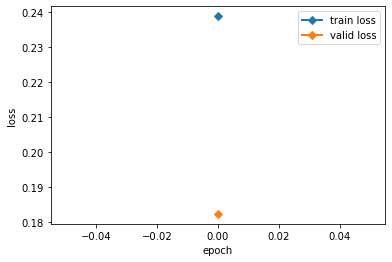

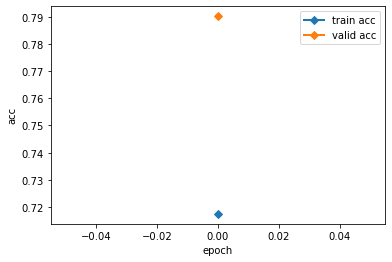


  7%|█████▎                                                                          | 1/15 [04:42<1:05:49, 282.11s/it]

Epoch 2/15
--------------------
train Loss: 0.1707 Acc: 0.7999
val Loss: 0.1462 Acc: 0.8350


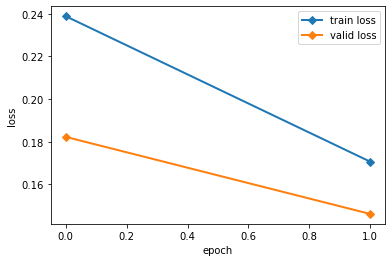

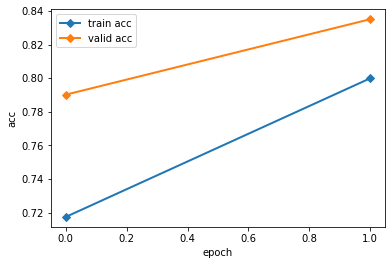


 13%|██████████▋                                                                     | 2/15 [09:19<1:00:48, 280.68s/it]

Epoch 3/15
--------------------
train Loss: 0.1539 Acc: 0.8207
val Loss: 0.1396 Acc: 0.8390


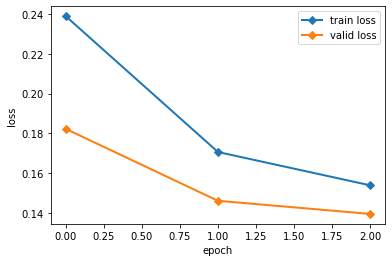

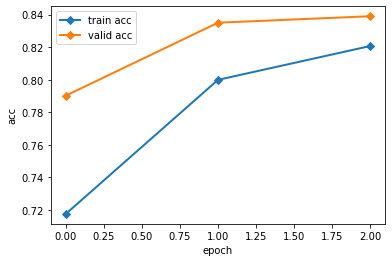


 20%|████████████████▍                                                                 | 3/15 [13:56<55:54, 279.52s/it]

Epoch 4/15
--------------------
train Loss: 0.1436 Acc: 0.8336
val Loss: 0.1446 Acc: 0.8334


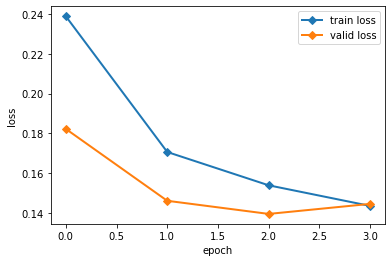

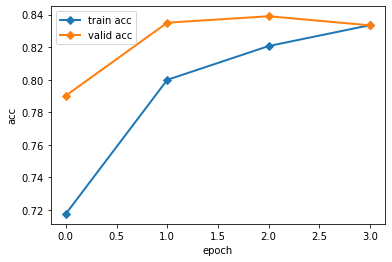


 27%|█████████████████████▊                                                            | 4/15 [18:33<51:07, 278.86s/it]

Epoch 5/15
--------------------
train Loss: 0.1361 Acc: 0.8434
val Loss: 0.1282 Acc: 0.8549


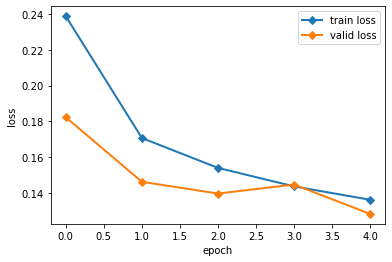

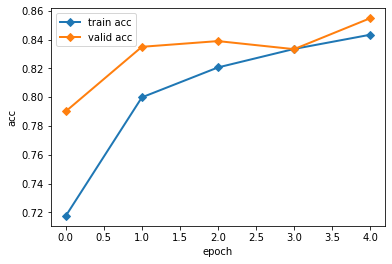


 33%|███████████████████████████▎                                                      | 5/15 [23:10<46:23, 278.35s/it]

Epoch 6/15
--------------------
train Loss: 0.1426 Acc: 0.8333
val Loss: 0.1286 Acc: 0.8514


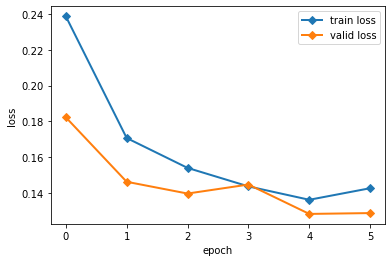

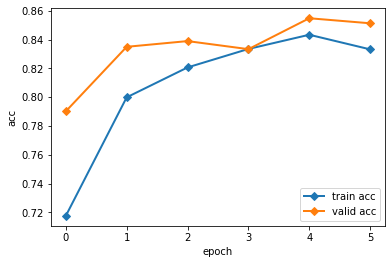


 40%|████████████████████████████████▊                                                 | 6/15 [27:48<41:42, 278.10s/it]

Epoch 7/15
--------------------
train Loss: 0.1360 Acc: 0.8419
val Loss: 0.1291 Acc: 0.8505


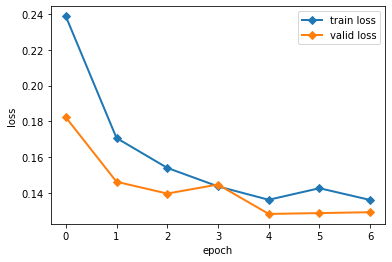

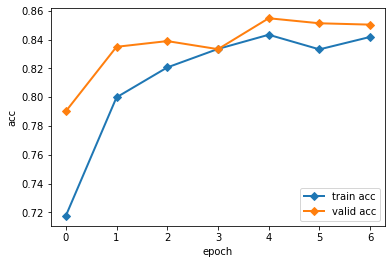


 47%|██████████████████████████████████████▎                                           | 7/15 [32:24<37:00, 277.61s/it]

Epoch 8/15
--------------------
train Loss: 0.1305 Acc: 0.8493
val Loss: 0.1253 Acc: 0.8554


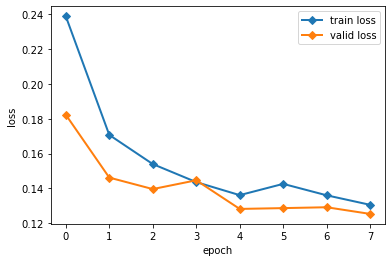

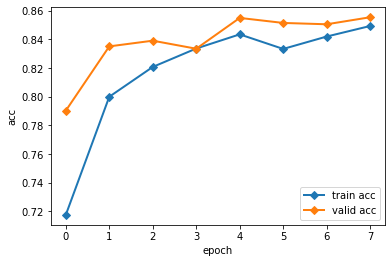


 53%|███████████████████████████████████████████▋                                      | 8/15 [37:00<32:19, 277.09s/it]

Epoch 9/15
--------------------
train Loss: 0.1205 Acc: 0.8619
val Loss: 0.1184 Acc: 0.8598


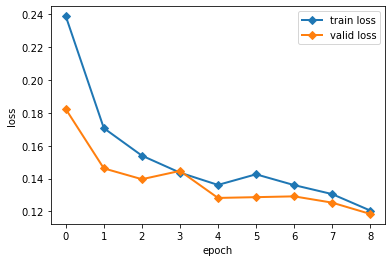

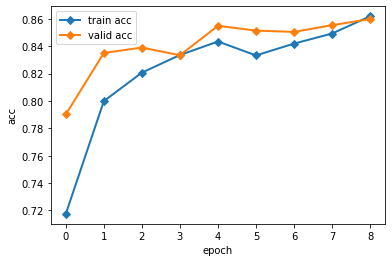


 60%|█████████████████████████████████████████████████▏                                | 9/15 [41:36<27:40, 276.80s/it]

Epoch 10/15
--------------------
train Loss: 0.1154 Acc: 0.8694
val Loss: 0.1230 Acc: 0.8577


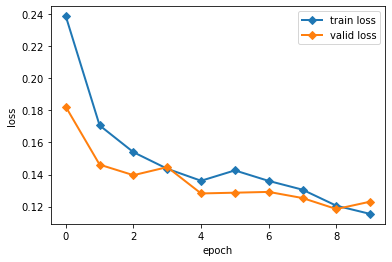

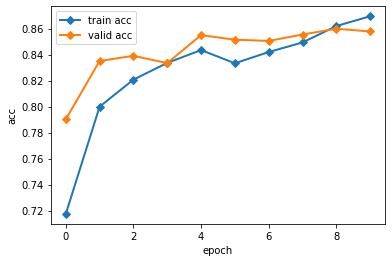


 67%|██████████████████████████████████████████████████████                           | 10/15 [46:12<23:02, 276.58s/it]

Epoch 11/15
--------------------
train Loss: 0.1236 Acc: 0.8593
val Loss: 0.1245 Acc: 0.8598


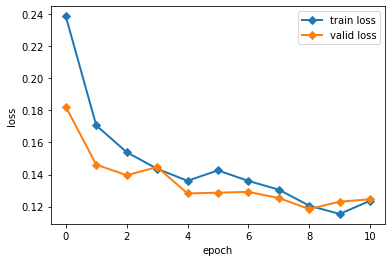

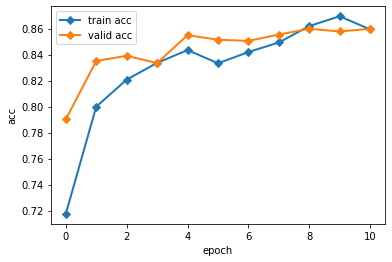


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [50:49<18:25, 276.46s/it]

Epoch 12/15
--------------------
train Loss: 0.1204 Acc: 0.8644
val Loss: 0.1183 Acc: 0.8607


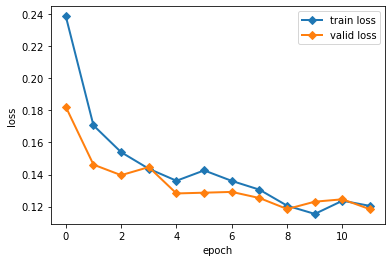

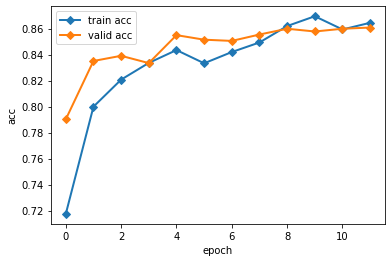


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [55:25<13:49, 276.44s/it]

Epoch 13/15
--------------------
train Loss: 0.1159 Acc: 0.8687
val Loss: 0.1146 Acc: 0.8659


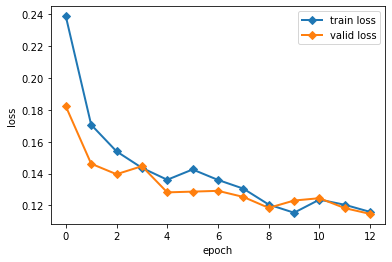

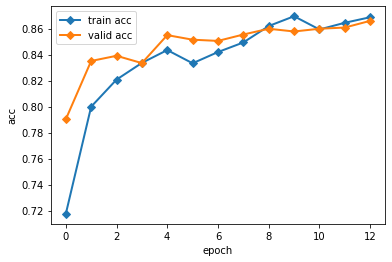


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [1:00:01<09:12, 276.46s/it]

Epoch 14/15
--------------------
train Loss: 0.1086 Acc: 0.8767
val Loss: 0.1152 Acc: 0.8682


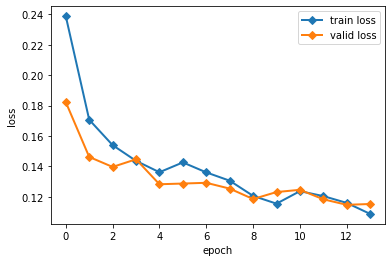

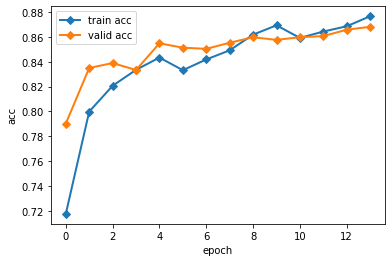


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:04:38<04:36, 276.41s/it]

Epoch 15/15
--------------------
train Loss: 0.1049 Acc: 0.8837
val Loss: 0.1187 Acc: 0.8659


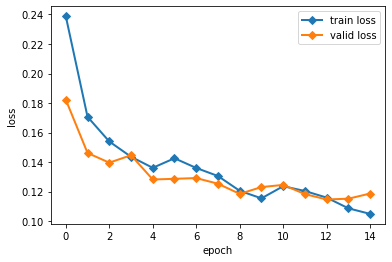

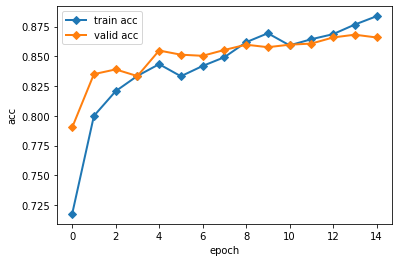


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:09:14<00:00, 276.95s/it]

Fold0 Running time:4155.788617134094[sec]


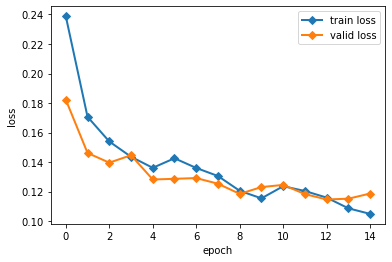

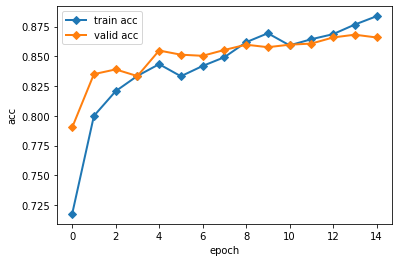

1it [1:09:16, 4156.22s/it]
  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1/15
--------------------
train Loss: 0.2396 Acc: 0.7206
val Loss: 0.1737 Acc: 0.7932


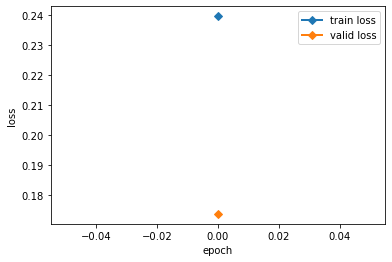

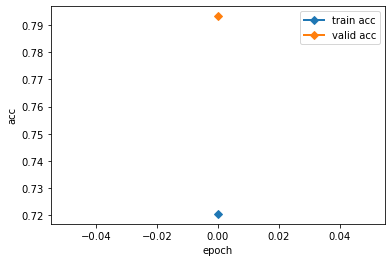


  7%|█████▎                                                                          | 1/15 [04:36<1:04:29, 276.43s/it]

Epoch 2/15
--------------------
train Loss: 0.1737 Acc: 0.7991
val Loss: 0.1541 Acc: 0.8175


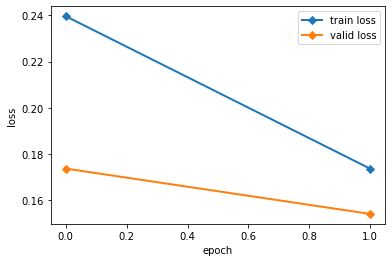

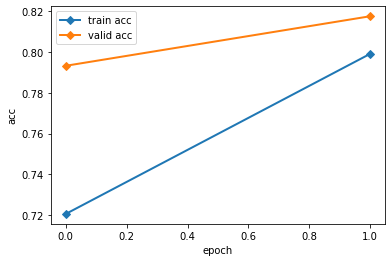


 13%|██████████▉                                                                       | 2/15 [09:05<59:23, 274.12s/it]

Epoch 3/15
--------------------
train Loss: 0.1540 Acc: 0.8201
val Loss: 0.1453 Acc: 0.8292


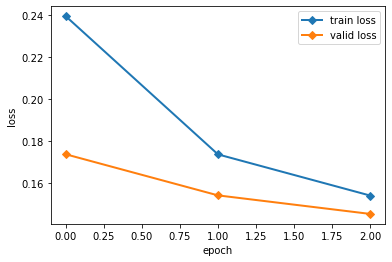

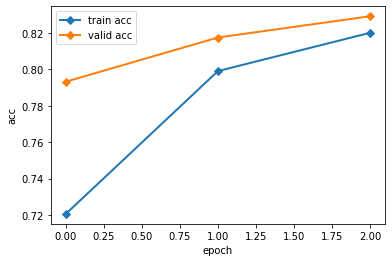


 20%|████████████████▍                                                                 | 3/15 [13:33<54:27, 272.26s/it]

Epoch 4/15
--------------------
train Loss: 0.1423 Acc: 0.8331
val Loss: 0.1317 Acc: 0.8432


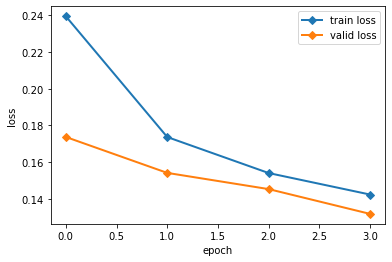

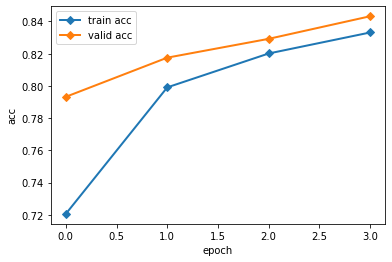


 27%|█████████████████████▊                                                            | 4/15 [18:01<49:40, 270.98s/it]

Epoch 5/15
--------------------
train Loss: 0.1382 Acc: 0.8396
val Loss: 0.1345 Acc: 0.8416


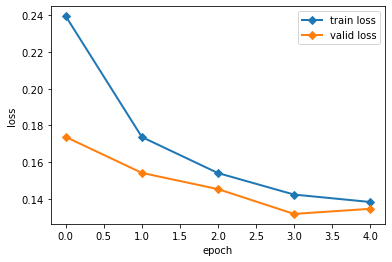

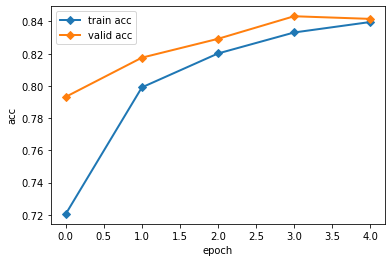


 33%|███████████████████████████▎                                                      | 5/15 [22:28<45:00, 270.05s/it]

Epoch 6/15
--------------------
train Loss: 0.1442 Acc: 0.8323
val Loss: 0.1315 Acc: 0.8442


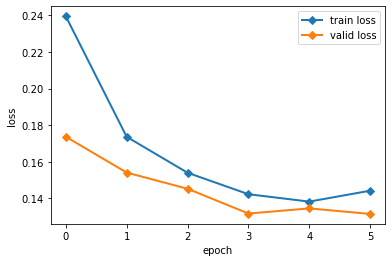

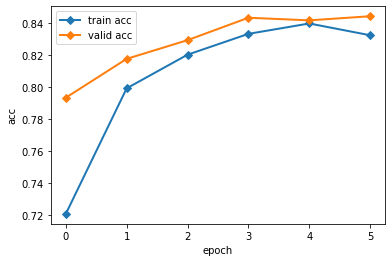


 40%|████████████████████████████████▊                                                 | 6/15 [26:56<40:24, 269.40s/it]

Epoch 7/15
--------------------
train Loss: 0.1365 Acc: 0.8424
val Loss: 0.1455 Acc: 0.8325


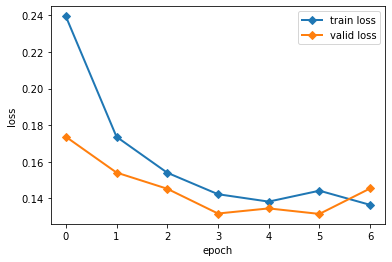

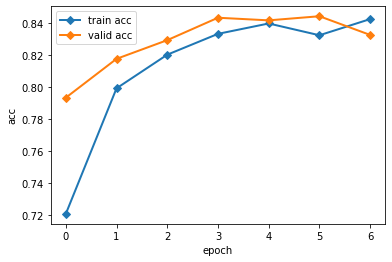


 47%|██████████████████████████████████████▎                                           | 7/15 [31:25<35:52, 269.07s/it]

Epoch 8/15
--------------------
train Loss: 0.1300 Acc: 0.8510
val Loss: 0.1268 Acc: 0.8507


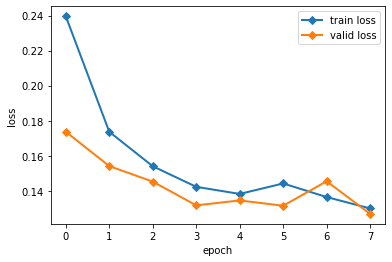

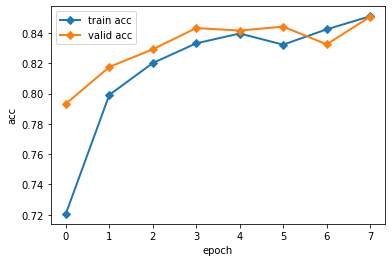


 53%|███████████████████████████████████████████▋                                      | 8/15 [35:53<31:21, 268.72s/it]

Epoch 9/15
--------------------
train Loss: 0.1275 Acc: 0.8527
val Loss: 0.1238 Acc: 0.8547


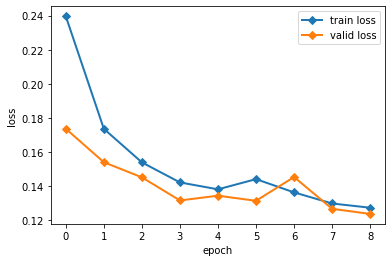

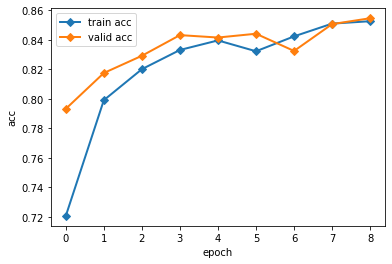


 60%|█████████████████████████████████████████████████▏                                | 9/15 [40:20<26:50, 268.47s/it]

Epoch 10/15
--------------------
train Loss: 0.1179 Acc: 0.8652
val Loss: 0.1222 Acc: 0.8549


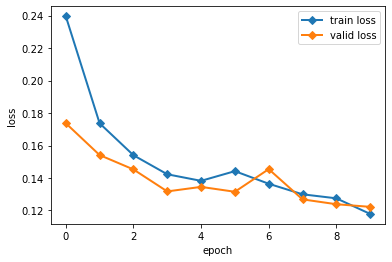

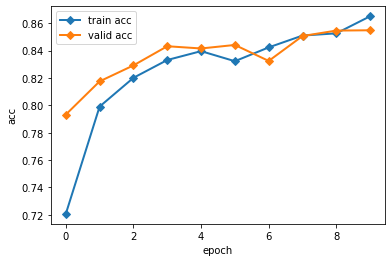


 67%|██████████████████████████████████████████████████████                           | 10/15 [44:48<22:21, 268.32s/it]

Epoch 11/15
--------------------
train Loss: 0.1251 Acc: 0.8575
val Loss: 0.1407 Acc: 0.8353


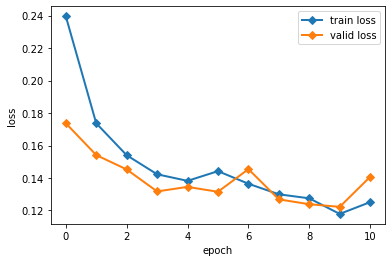

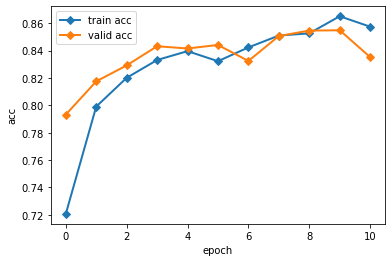


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [49:16<17:52, 268.07s/it]

Epoch 12/15
--------------------
train Loss: 0.1234 Acc: 0.8580
val Loss: 0.1240 Acc: 0.8565


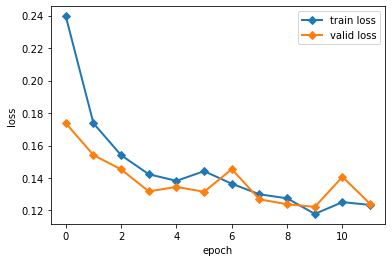

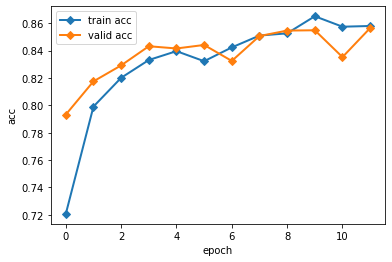


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [53:43<13:23, 267.93s/it]

Epoch 13/15
--------------------
train Loss: 0.1178 Acc: 0.8679
val Loss: 0.1203 Acc: 0.8610


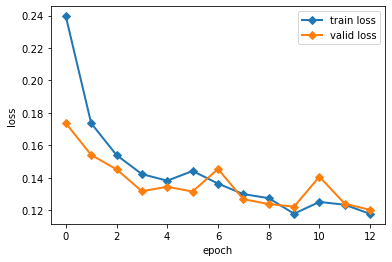

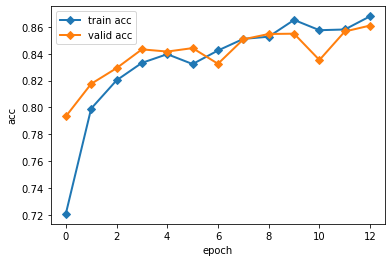


 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [58:11<08:55, 267.87s/it]

Epoch 14/15
--------------------
train Loss: 0.1110 Acc: 0.8738
val Loss: 0.1237 Acc: 0.8591


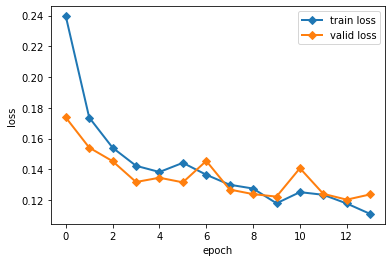

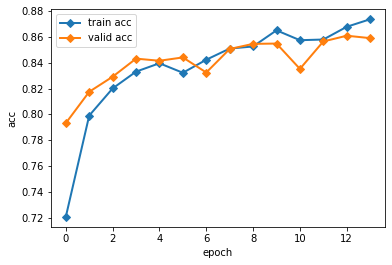


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:02:40<04:28, 268.05s/it]

Epoch 15/15
--------------------
train Loss: 0.1051 Acc: 0.8817
val Loss: 0.1224 Acc: 0.8612


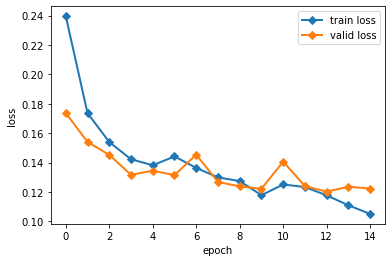

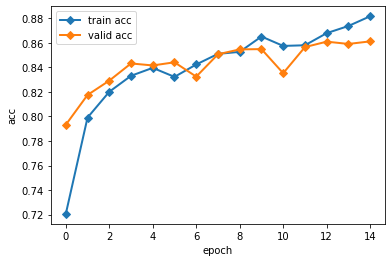


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:07:07<00:00, 268.51s/it]

Fold1 Running time:4028.163877725601[sec]


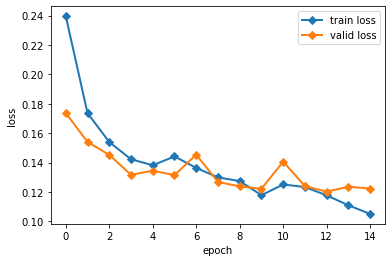

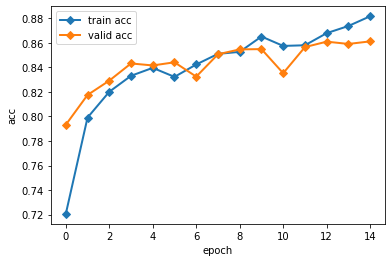

2it [2:16:24, 4117.93s/it]
  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1/15
--------------------
train Loss: 0.2367 Acc: 0.7251
val Loss: 0.1739 Acc: 0.7969


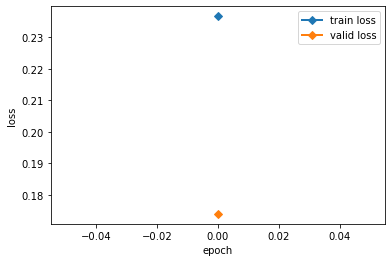

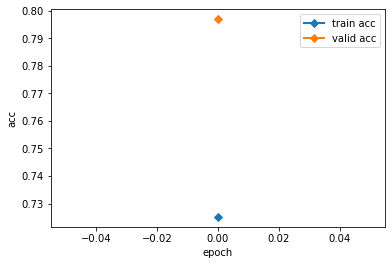


  7%|█████▎                                                                          | 1/15 [04:29<1:02:48, 269.15s/it]

Epoch 2/15
--------------------
train Loss: 0.1682 Acc: 0.8040
val Loss: 0.1536 Acc: 0.8203


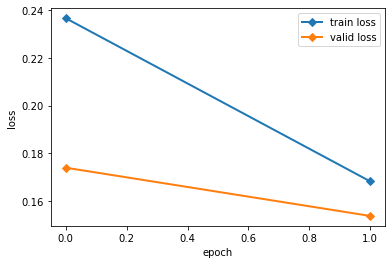

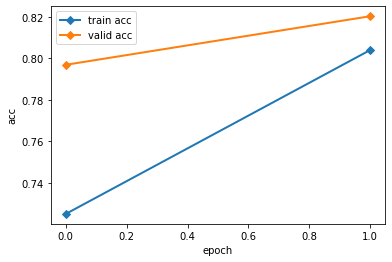


 13%|██████████▉                                                                       | 2/15 [08:56<58:10, 268.51s/it]

Epoch 3/15
--------------------
train Loss: 0.1539 Acc: 0.8207
val Loss: 0.1401 Acc: 0.8371


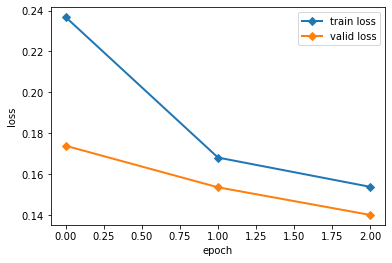

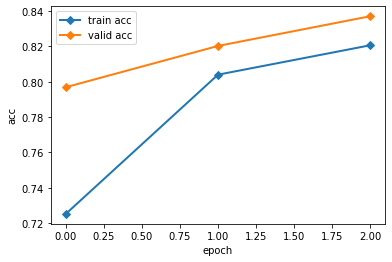


 20%|████████████████▍                                                                 | 3/15 [13:23<53:37, 268.13s/it]

Epoch 4/15
--------------------
train Loss: 0.1409 Acc: 0.8381
val Loss: 0.1340 Acc: 0.8453


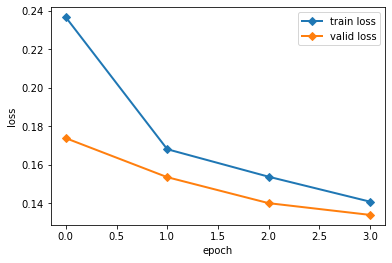

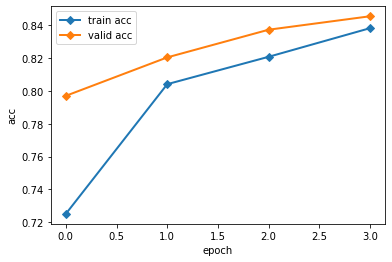


 27%|█████████████████████▊                                                            | 4/15 [17:51<49:07, 267.98s/it]

Epoch 5/15
--------------------
train Loss: 0.1371 Acc: 0.8412
val Loss: 0.1327 Acc: 0.8460


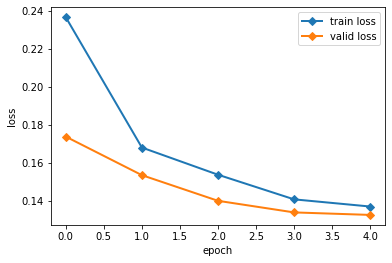

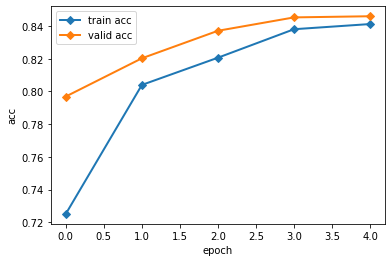


 33%|███████████████████████████▎                                                      | 5/15 [22:18<44:38, 267.89s/it]

Epoch 6/15
--------------------
train Loss: 0.1417 Acc: 0.8352
val Loss: 0.1399 Acc: 0.8373


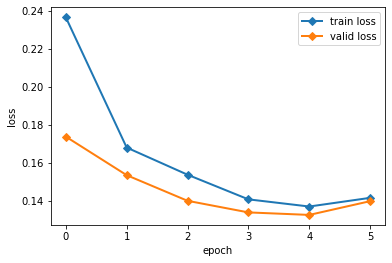

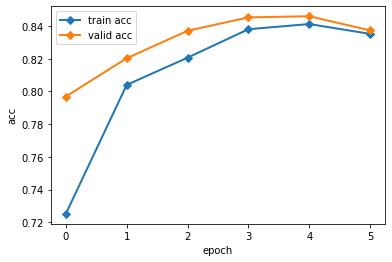


 40%|████████████████████████████████▊                                                 | 6/15 [26:46<40:10, 267.78s/it]

Epoch 7/15
--------------------
train Loss: 0.1362 Acc: 0.8429
val Loss: 0.1314 Acc: 0.8500


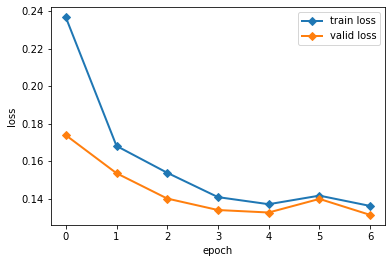

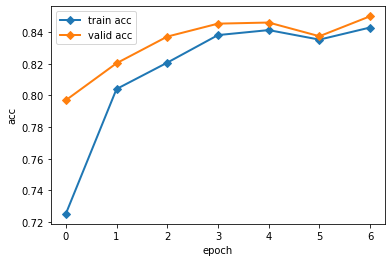


 47%|██████████████████████████████████████▎                                           | 7/15 [31:15<35:44, 268.08s/it]

Epoch 8/15
--------------------
train Loss: 0.1273 Acc: 0.8523
val Loss: 0.1275 Acc: 0.8530


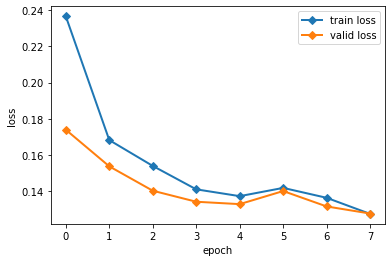

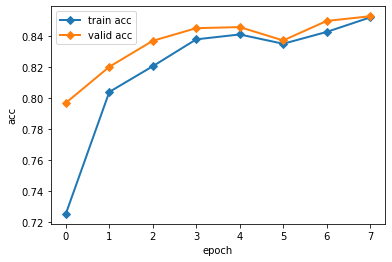


 53%|███████████████████████████████████████████▋                                      | 8/15 [35:42<31:15, 267.93s/it]

Epoch 9/15
--------------------
train Loss: 0.1240 Acc: 0.8577
val Loss: 0.1241 Acc: 0.8558


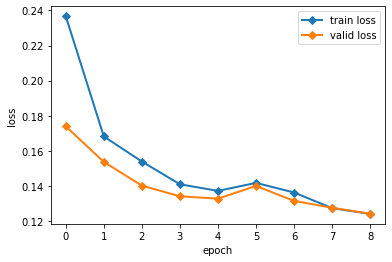

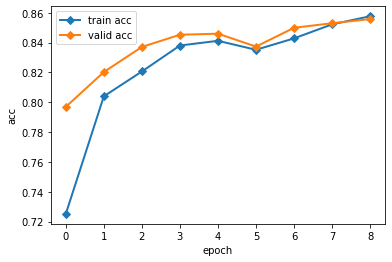


 60%|█████████████████████████████████████████████████▏                                | 9/15 [40:09<26:46, 267.74s/it]

Epoch 10/15
--------------------
train Loss: 0.1177 Acc: 0.8671
val Loss: 0.1265 Acc: 0.8577


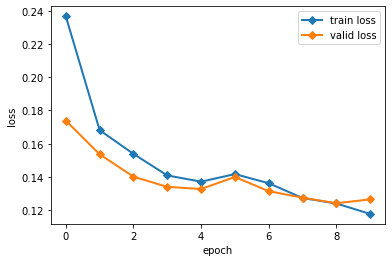

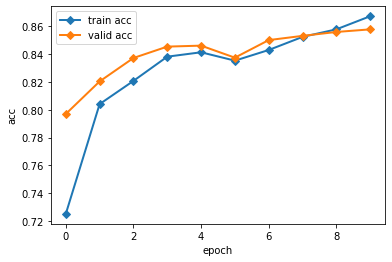


 67%|██████████████████████████████████████████████████████                           | 10/15 [44:37<22:17, 267.57s/it]

Epoch 11/15
--------------------
train Loss: 0.1237 Acc: 0.8589
val Loss: 0.1269 Acc: 0.8528


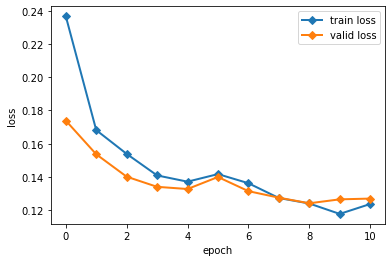

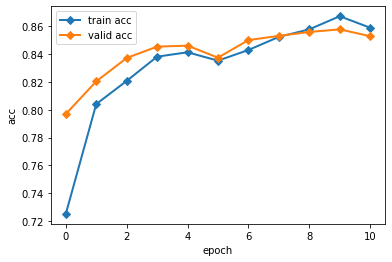


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [49:04<17:50, 267.52s/it]

Epoch 12/15
--------------------
train Loss: 0.1226 Acc: 0.8596
val Loss: 0.1351 Acc: 0.8441


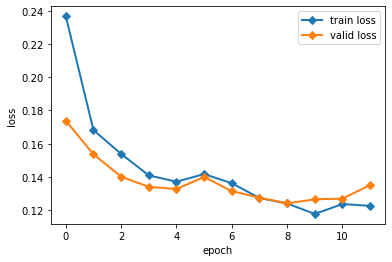

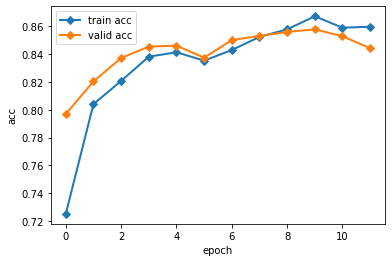


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [53:31<13:22, 267.49s/it]

Epoch 13/15
--------------------
train Loss: 0.1159 Acc: 0.8655
val Loss: 0.1288 Acc: 0.8521


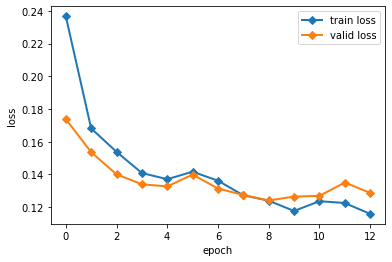

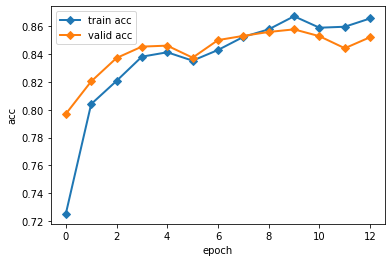


 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [57:59<08:55, 267.52s/it]

Epoch 14/15
--------------------
train Loss: 0.1115 Acc: 0.8723
val Loss: 0.1219 Acc: 0.8621


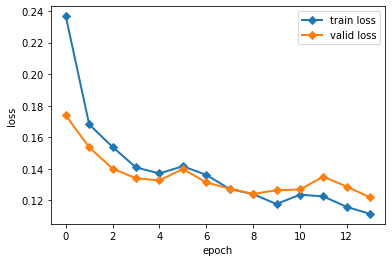

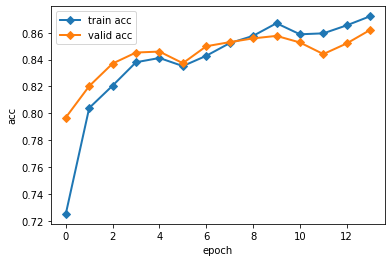


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:02:26<04:27, 267.48s/it]

Epoch 15/15
--------------------
train Loss: 0.1052 Acc: 0.8809
val Loss: 0.1228 Acc: 0.8581


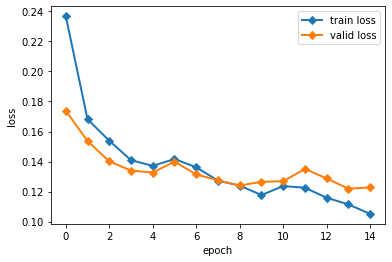

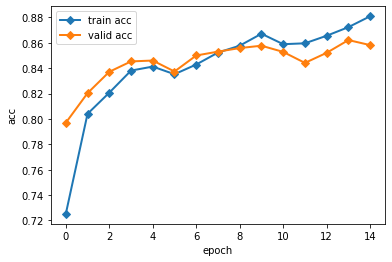


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:06:54<00:00, 267.64s/it]

Fold2 Running time:4015.125291109085[sec]


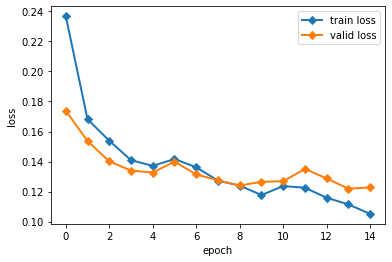

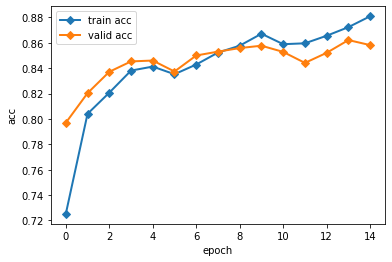

3it [3:23:20, 4087.22s/it]
  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1/15
--------------------
train Loss: 0.2379 Acc: 0.7219
val Loss: 0.1663 Acc: 0.8056


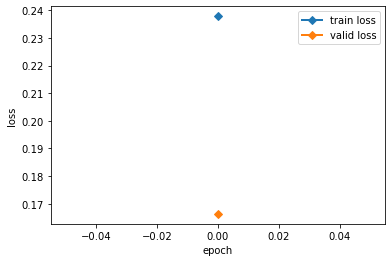

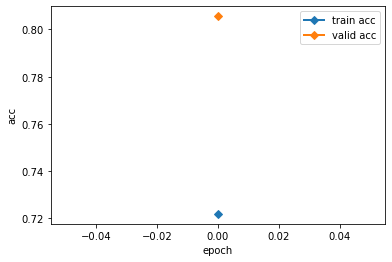


  7%|█████▎                                                                          | 1/15 [04:28<1:02:34, 268.20s/it]

Epoch 2/15
--------------------
train Loss: 0.1718 Acc: 0.7986
val Loss: 0.1424 Acc: 0.8366


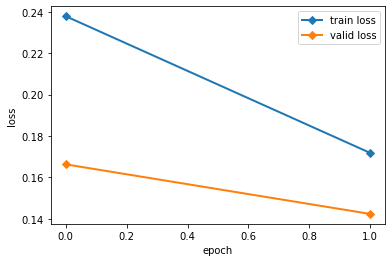

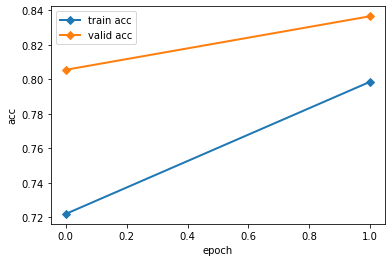


 13%|██████████▉                                                                       | 2/15 [08:56<58:05, 268.14s/it]

Epoch 3/15
--------------------
train Loss: 0.1521 Acc: 0.8200
val Loss: 0.1436 Acc: 0.8364


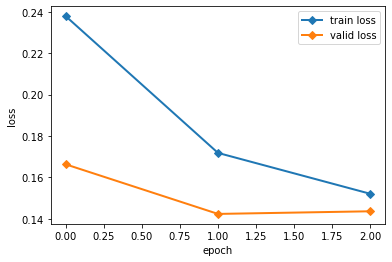

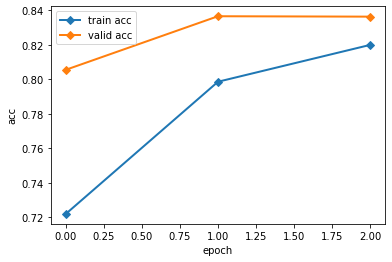


 20%|████████████████▍                                                                 | 3/15 [13:24<53:38, 268.17s/it]

Epoch 4/15
--------------------
train Loss: 0.1415 Acc: 0.8346
val Loss: 0.1312 Acc: 0.8504


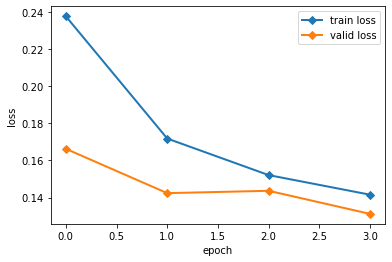

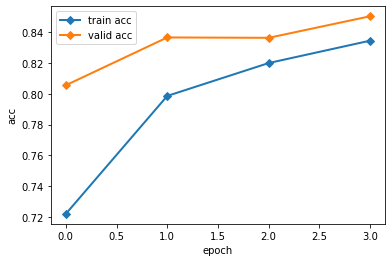


 27%|█████████████████████▊                                                            | 4/15 [17:52<49:10, 268.25s/it]

Epoch 5/15
--------------------
train Loss: 0.1372 Acc: 0.8409
val Loss: 0.1325 Acc: 0.8490


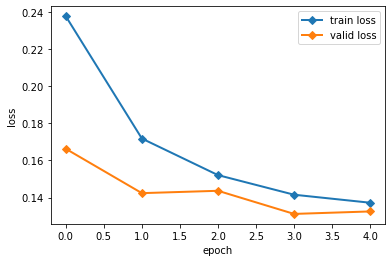

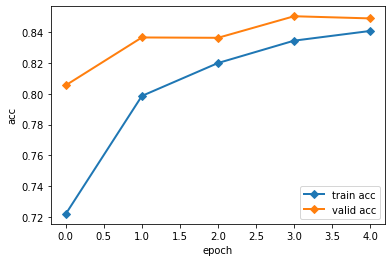


 33%|███████████████████████████▎                                                      | 5/15 [22:20<44:41, 268.14s/it]

Epoch 6/15
--------------------
train Loss: 0.1418 Acc: 0.8355
val Loss: 0.1341 Acc: 0.8448


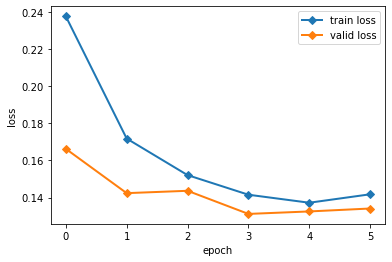

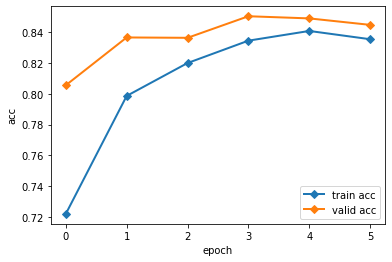


 40%|████████████████████████████████▊                                                 | 6/15 [26:48<40:11, 267.97s/it]

Epoch 7/15
--------------------
train Loss: 0.1357 Acc: 0.8422
val Loss: 0.1396 Acc: 0.8380


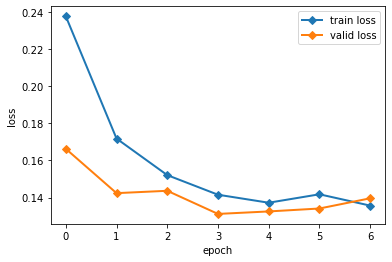

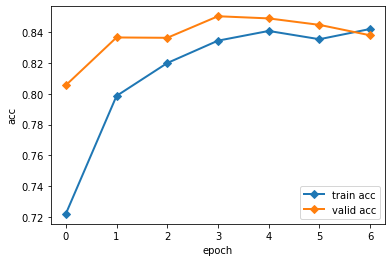


 47%|██████████████████████████████████████▎                                           | 7/15 [31:15<35:42, 267.83s/it]

Epoch 8/15
--------------------
train Loss: 0.1295 Acc: 0.8507
val Loss: 0.1292 Acc: 0.8476


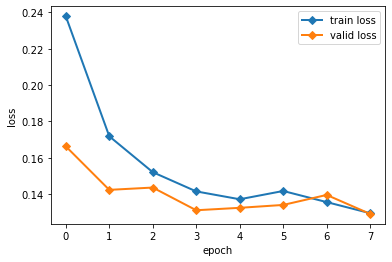

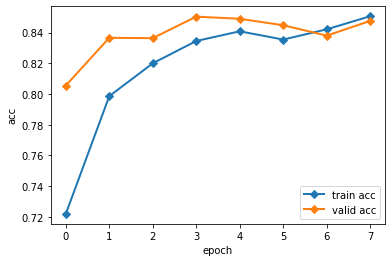


 53%|███████████████████████████████████████████▋                                      | 8/15 [35:43<31:15, 267.91s/it]

Epoch 9/15
--------------------
train Loss: 0.1199 Acc: 0.8641
val Loss: 0.1229 Acc: 0.8577


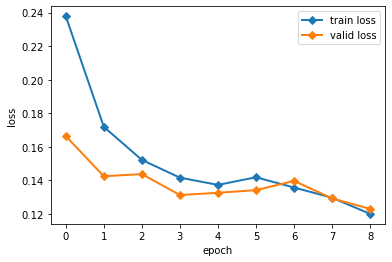

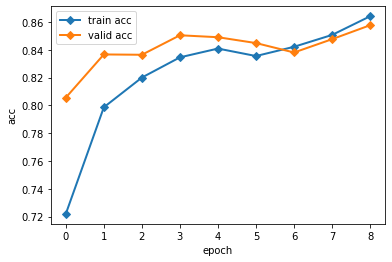


 60%|█████████████████████████████████████████████████▏                                | 9/15 [40:11<26:46, 267.83s/it]

Epoch 10/15
--------------------
train Loss: 0.1151 Acc: 0.8683
val Loss: 0.1263 Acc: 0.8558


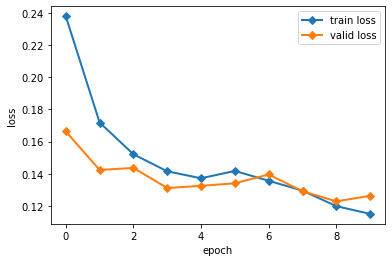

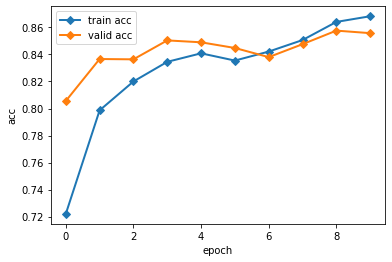


 67%|██████████████████████████████████████████████████████                           | 10/15 [44:38<22:18, 267.69s/it]

Epoch 11/15
--------------------
train Loss: 0.1262 Acc: 0.8541
val Loss: 0.1317 Acc: 0.8474


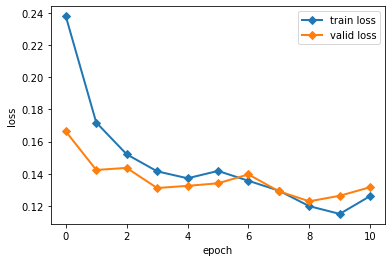

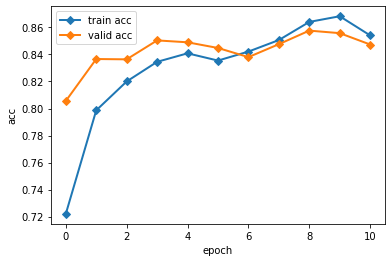


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [49:06<17:51, 267.79s/it]

Epoch 12/15
--------------------
train Loss: 0.1225 Acc: 0.8607
val Loss: 0.1293 Acc: 0.8511


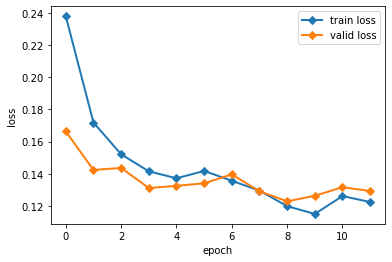

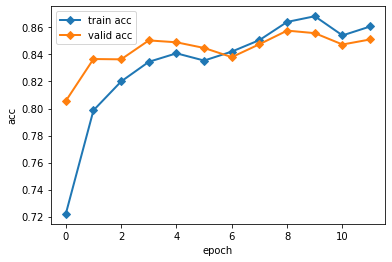


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [53:35<13:23, 267.91s/it]

Epoch 13/15
--------------------
train Loss: 0.1164 Acc: 0.8663
val Loss: 0.1275 Acc: 0.8567


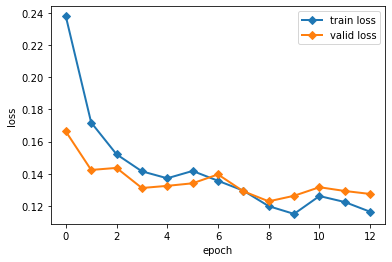

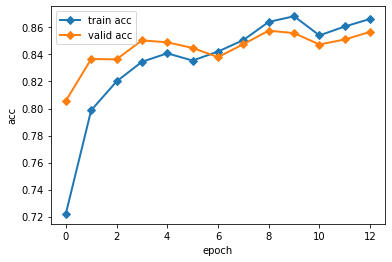


 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [58:03<08:55, 267.90s/it]

Epoch 14/15
--------------------
train Loss: 0.1095 Acc: 0.8757
val Loss: 0.1246 Acc: 0.8593


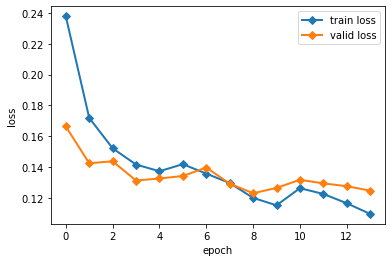

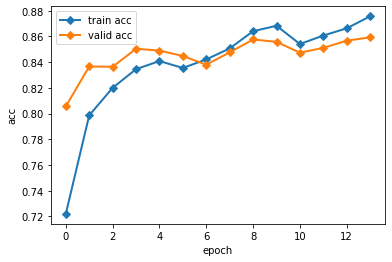


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:02:31<04:27, 267.94s/it]

Epoch 15/15
--------------------
train Loss: 0.1032 Acc: 0.8843
val Loss: 0.1253 Acc: 0.8577


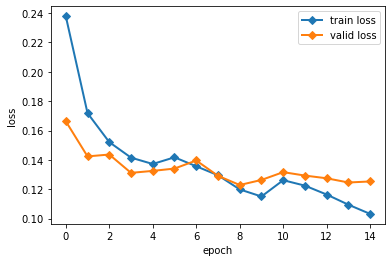

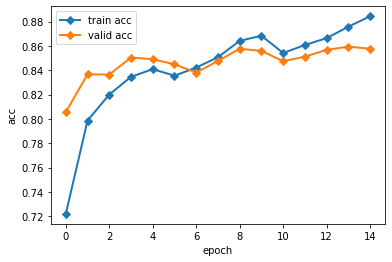


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:06:59<00:00, 267.95s/it]

Fold3 Running time:4019.6595656871796[sec]


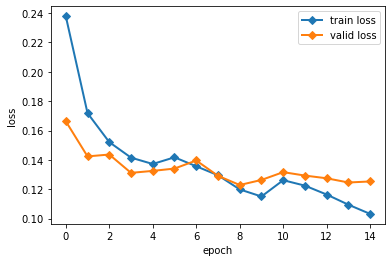

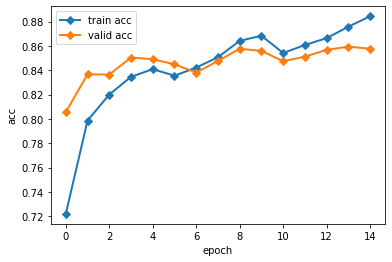

4it [4:30:20, 4067.08s/it]
  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1/15
--------------------
train Loss: 0.2381 Acc: 0.7211
val Loss: 0.1728 Acc: 0.7976


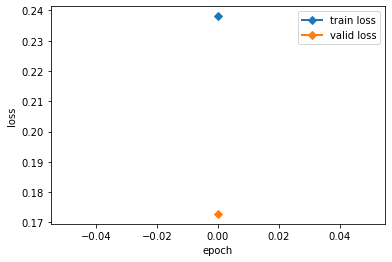

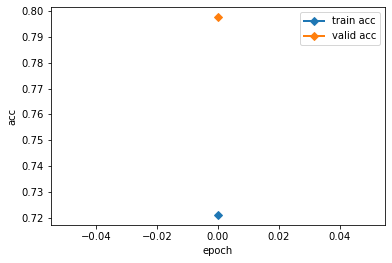


  7%|█████▎                                                                          | 1/15 [04:27<1:02:26, 267.64s/it]

Epoch 2/15
--------------------
train Loss: 0.1713 Acc: 0.7993
val Loss: 0.1583 Acc: 0.8091


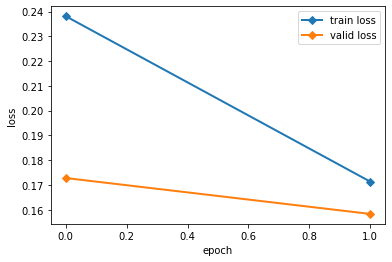

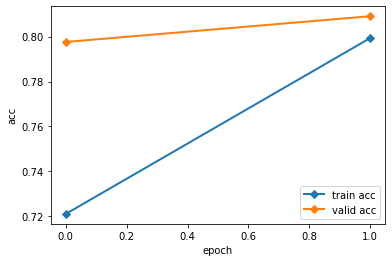


 13%|██████████▉                                                                       | 2/15 [08:55<57:59, 267.65s/it]

Epoch 3/15
--------------------
train Loss: 0.1531 Acc: 0.8203
val Loss: 0.1439 Acc: 0.8278


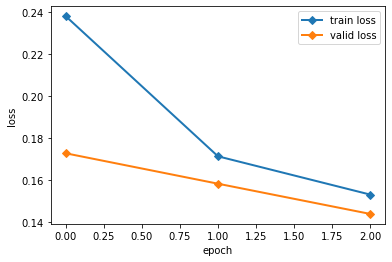

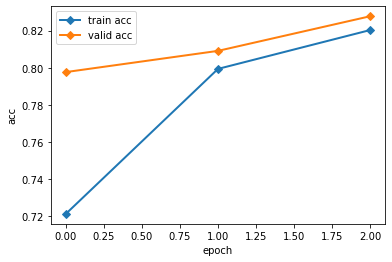


 20%|████████████████▍                                                                 | 3/15 [13:22<53:29, 267.47s/it]

Epoch 4/15
--------------------
train Loss: 0.1425 Acc: 0.8346
val Loss: 0.1392 Acc: 0.8390


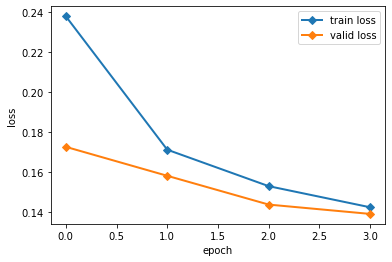

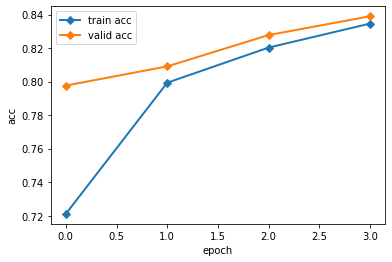


 27%|█████████████████████▊                                                            | 4/15 [17:50<49:02, 267.53s/it]

Epoch 5/15
--------------------
train Loss: 0.1357 Acc: 0.8429
val Loss: 0.1399 Acc: 0.8373


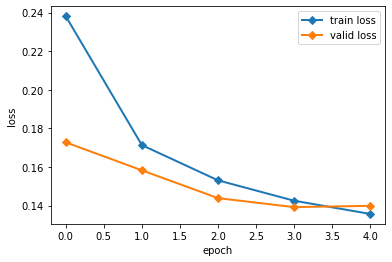

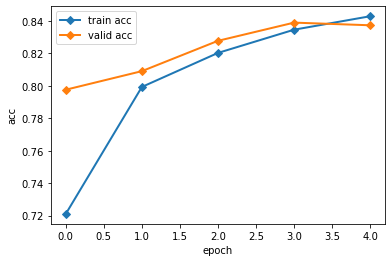


 33%|███████████████████████████▎                                                      | 5/15 [22:17<44:33, 267.39s/it]

Epoch 6/15
--------------------
train Loss: 0.1437 Acc: 0.8330
val Loss: 0.1405 Acc: 0.8343


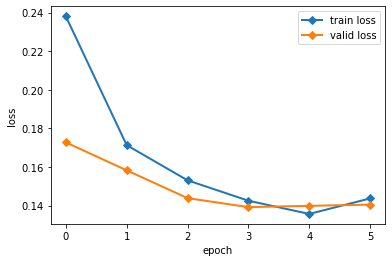

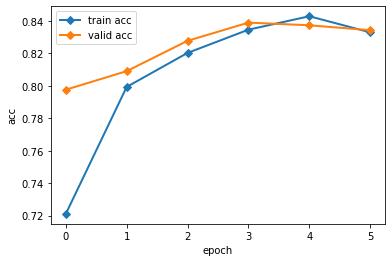


 40%|████████████████████████████████▊                                                 | 6/15 [26:44<40:07, 267.46s/it]

Epoch 7/15
--------------------
train Loss: 0.1362 Acc: 0.8434
val Loss: 0.1308 Acc: 0.8479


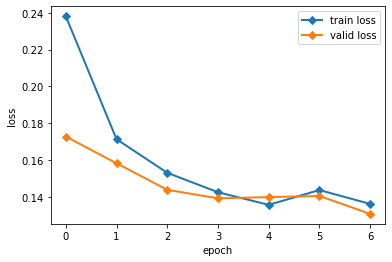

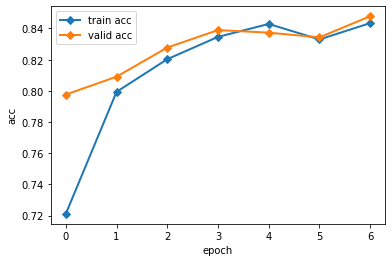


 47%|██████████████████████████████████████▎                                           | 7/15 [31:12<35:40, 267.53s/it]

Epoch 8/15
--------------------
train Loss: 0.1306 Acc: 0.8486
val Loss: 0.1373 Acc: 0.8380


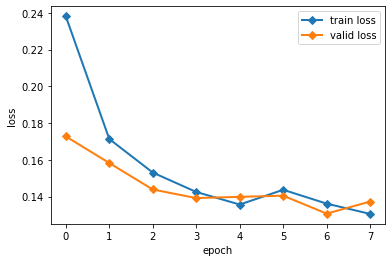

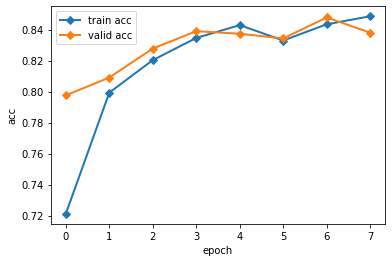


 53%|███████████████████████████████████████████▋                                      | 8/15 [35:40<31:13, 267.64s/it]

Epoch 9/15
--------------------
train Loss: 0.1220 Acc: 0.8608
val Loss: 0.1294 Acc: 0.8518


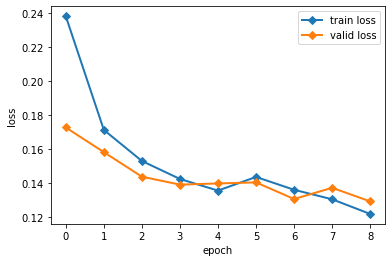

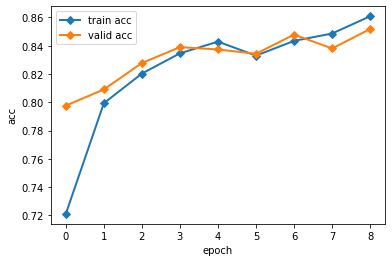


 60%|█████████████████████████████████████████████████▏                                | 9/15 [40:07<26:45, 267.57s/it]

Epoch 10/15
--------------------
train Loss: 0.1165 Acc: 0.8663
val Loss: 0.1257 Acc: 0.8565


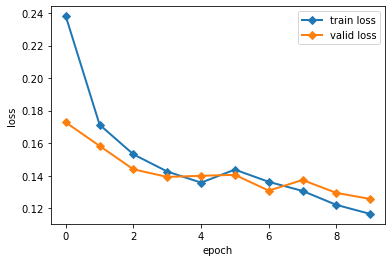

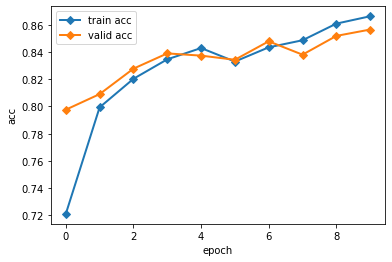


 67%|██████████████████████████████████████████████████████                           | 10/15 [44:34<22:17, 267.46s/it]

Epoch 11/15
--------------------
train Loss: 0.1256 Acc: 0.8565
val Loss: 0.1320 Acc: 0.8479


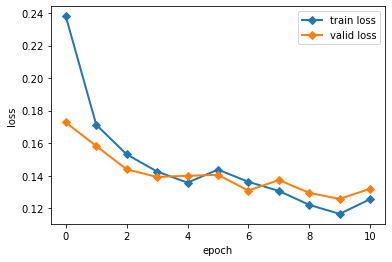

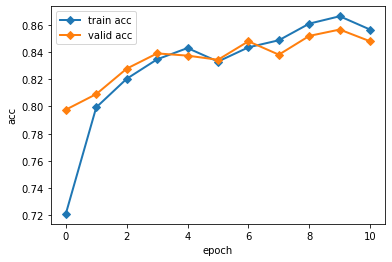


 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [49:02<17:49, 267.50s/it]

Epoch 12/15
--------------------
train Loss: 0.1209 Acc: 0.8607
val Loss: 0.1248 Acc: 0.8567


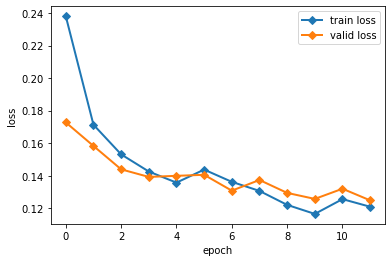

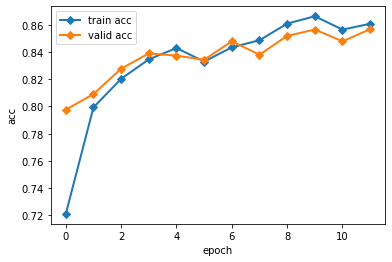


 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [53:29<13:22, 267.38s/it]

Epoch 13/15
--------------------
train Loss: 0.1154 Acc: 0.8681
val Loss: 0.1253 Acc: 0.8535


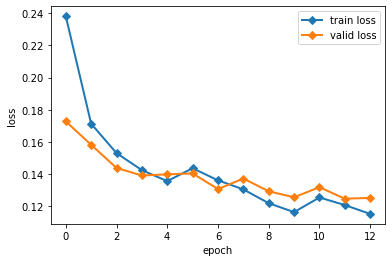

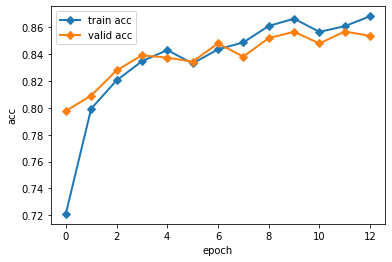


 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [57:57<08:55, 267.55s/it]

Epoch 14/15
--------------------
train Loss: 0.1100 Acc: 0.8742
val Loss: 0.1287 Acc: 0.8490


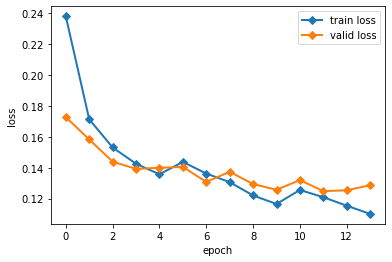

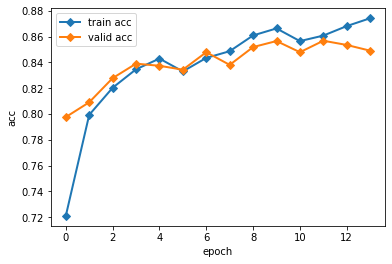


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:02:25<04:27, 267.68s/it]

Epoch 15/15
--------------------
train Loss: 0.1032 Acc: 0.8843
val Loss: 0.1251 Acc: 0.8549


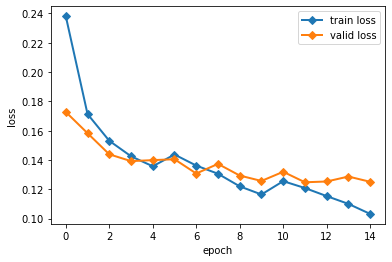

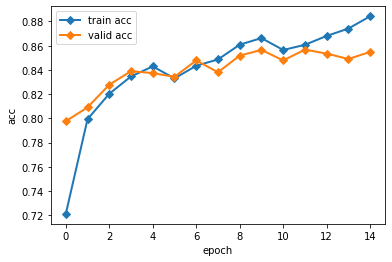


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:06:53<00:00, 267.57s/it]

Fold4 Running time:4013.9830124378204[sec]


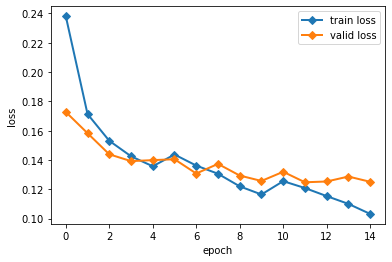

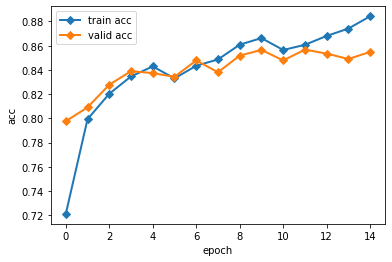

5it [5:37:14, 4046.98s/it]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


In [23]:
if __name__ == "__main__":
    set_random_seed(config['seed'])
    
    # device setting
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("use device: ", device)

    # CV loop
    folds = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (train_idx, val_idx) in tqdm(enumerate(folds)):
        time_start = time.time()
#         if fold > 0:
#             break
        
        # Dataset
        train_filepath2label = dict(zip(train.loc[train_idx, :].image_path, train.loc[train_idx, :].label))
        val_filepath2label = dict(zip(train.loc[val_idx, :].image_path, train.loc[val_idx, :].label))

        train_dataset = CassavaDataset(train_filepath2label, ImageTransform(config['aug']['size'], config['aug']['mean'], config['aug']['std'], config['aug']['degrees'], config['aug']['brightness'], config['aug']['brightness']), config['aug']['ver'], 'train', True)
        val_dataset = CassavaDataset(val_filepath2label, ImageTransform(config['aug']['size'], config['aug']['mean'], config['aug']['std'], config['aug']['degrees'], config['aug']['brightness'], config['aug']['brightness']), config['aug']['ver'], 'val', True)
        
        # DataLoader
        train_dataloader = get_DataLoader(train_dataset, config['batch_size'], True)
        val_dataloader = get_DataLoader(val_dataset, config['batch_size'], True)
        dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}
        
        # get NetWork model
        use_pretrained = True
        net, update_param_names = get_network(config['model_name'], use_pretrained)
        
        # set train mode
        net.train()
        
        # GradScaler
        scaler = GradScaler() 

        # criterion
        criterion = get_criterion(config['loss']['name'], config['loss'])

        # get optimizer
        params_to_update = set_params(net, update_param_names, config['set_all'])
        optimizer = get_optimizer(config['optim']['name'], params_to_update)
        
        # scheduler
        scheduler = get_scheduler(optimizer)
        
        # train & valid
        net, epoch_result_dict = train_model(net, dataloaders_dict, criterion, optimizer, config['num_epochs'], scheduler, device)
        
        elapsed_time = time.time() - time_start
        print("Fold{} Running time:{}".format(fold, elapsed_time) + "[sec]")
        
        # plot train & val loss (each epoch)
        figname = make_filename_info('loss', '.png', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'])
        plt.plot(range(len(epoch_result_dict['train']['loss'])), epoch_result_dict['train']['loss'], label='train loss', linewidth=2, marker='D')
        plt.plot(range(len(epoch_result_dict['val']['loss'])), epoch_result_dict['val']['loss'], label='valid loss', linewidth=2, marker='D')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(osp.join('fig', figname))
        plt.show()

        # plot train & val ACC (each epoch)
        figname = make_filename_info('acc', '.png', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'])
        plt.plot(range(len(epoch_result_dict['train']['acc'])), epoch_result_dict['train']['acc'], label='train acc', linewidth=2, marker='D')
        plt.plot(range(len(epoch_result_dict['val']['acc'])), epoch_result_dict['val']['acc'], label='valid acc', linewidth=2, marker='D')
        plt.xlabel('epoch')
        plt.ylabel('acc')
        plt.legend()
        plt.savefig(osp.join('fig', figname))
        plt.show()

        # save model
        filename = make_filename_info('model', '.pth', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'])
        save_path = osp.join('trained_model', filename)
        torch.save(net.state_dict(), save_path)

    # prediction for test dataset
    test_datalist = make_datapath_list(config['rootpath'], 'test')
    test_filepath2label = dict(zip(test_datalist, [0] * len(test_datalist)))
    test_dataset = CassavaDataset(test_filepath2label, ImageTransform(config['aug']['size'], config['aug']['mean'], config['aug']['std'], config['aug']['degrees'], config['aug']['brightness'], config['aug']['brightness']), config['aug']['ver'], 'test', False)
    test_dataloader = get_DataLoader(test_dataset, config['batch_size'], False)
    
    test_preds = inference_test_data(net, test_dataloader, device)
    
    # make submission.csv
    submission = pd.DataFrame({'image_id': [osp.basename(k) for k in test_datalist], 'label': test_preds})
    submission.to_csv('submission.csv', index=False)